In [1]:
import os, json
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

# Reading and cleaning the data

To extract the data from the Endomondo export, I first create a list of all workout files.

In [2]:
path_to_json = 'workouts/'
json_files = [pos_json for pos_json in os.listdir(path_to_json) if pos_json.endswith('.json')]

Then, from each file, I extract the data I need and append it to a list, so every list item is a json.

In [3]:
data = []

for f in json_files:
    with open('workouts/'+f) as json_file:
        json_data = json.load(json_file)

        d = {}
        for j in json_data:
            d.update(dict(j))

        if d['sport'] == 'WALKING':
            data.append(d)

Then I can use the list of jsons to create a data frame.

In [4]:
df = pd.DataFrame(data)
df = df[['start_time', 'distance_km', 'duration_s', 'speed_avg_kmh']]

Fixing some data type and unit tings.

In [5]:
df['start_time'] = pd.to_datetime(df['start_time'], format='%Y/%m/%d').dt.normalize()
df['duration_min'] = df['duration_s'] / 60
df.head()

,start_time,distance_km,duration_s,speed_avg_kmh,duration_min
0,2020-03-13,1.179,681.77,6.225560,11.362833
1,2017-04-29,6.504,3686.43,6.351511,61.440500
2,2017-05-15,2.195,1458.99,5.416075,24.316500
3,2017-10-09,3.599,2351.28,5.510360,39.188000
4,2017-10-11,2.388,1517.30,5.665854,25.288333


Since I only need data from Feb and March 2020, I filter out the rest.

In [6]:
df = df[df['start_time']>='2020-02-01'].sort_values(by='start_time')
df.reset_index(inplace=True, drop=True)
print(f'number of datapoints: {len(df)}')

number of datapoints: 38


# Analysis

Since I'm mainly interested in average walking speed, let's see its descriptive statistics.

In [7]:
df[['speed_avg_kmh']].describe()

,speed_avg_kmh
count,38.000000
mean,6.026441
std,0.297371
min,5.535161
25%,5.780796
50%,6.038148
75%,6.219591
max,6.892989


Then, let's try to visualise the relationship between distance and duration in a scatter plot. We should see a nice linear correlation.

In order to draw the regression line, we need to calculate its formula.

In [8]:
from sklearn.linear_model import LinearRegression

In [9]:
model = LinearRegression()

In [10]:
x = df[['distance_km']]
y = df[['duration_min']]
model.fit(x, y)
model = LinearRegression().fit(x, y)

Now we can extract the y-intercept and the slop of the line.

In [11]:
intercept = model.intercept_[0]
slope = model.coef_[0][0]

print('intercept:', intercept)
print('slope:', slope)

intercept: 0.3217424666737756
slope: 9.779546814599154


And now finally to the visualisation.

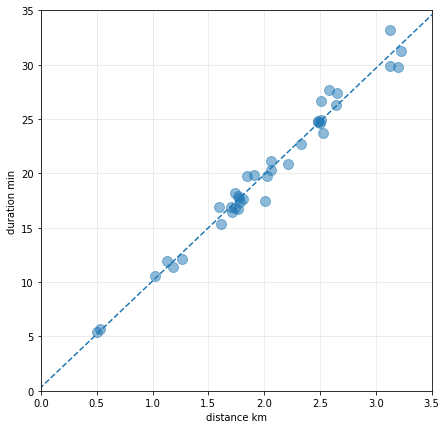

In [12]:
fig,ax = plt.subplots(figsize = (7, 7))

# plot the dots for scatter
X = df[['distance_km']]
Y = df[['duration_min']]
plt.scatter(X, Y, s=100, alpha=.5, zorder=3)

# plot the regression line
x = np.linspace(np.min(X)-1, np.max(X)+1, 1000)
y = intercept + slope * x
plt.plot(x, y, linestyle='--', label='Regression Line', zorder=2)

# tweaks
ax.set_xlabel('distance km')
ax.set_ylabel('duration min')
ax.set_xlim(0, 3.5)
ax.set_ylim(0, 35)
plt.grid(which='major', zorder=0, color='#E8E8E8')

# plt.savefig('scatter.png', bbox_inches='tight', dpi=200)

plt.show()

We already learned before that my average walking speed was 6.03 km/h. According to Google, the average walking speed is some 5.2 km/h. So how do I compare? Am I significantly faster than an average person? Let's do a t-test.

In [13]:
import scipy.stats

In [14]:
pop_mean = 5.2
scipy.stats.ttest_1samp(df['speed_avg_kmh'], pop_mean)

Ttest_1sampResult(statistic=17.1318870129101, pvalue=3.518159029717419e-19)

The p value is very very small, so we can conclude that I am faster than an averge person.